In [42]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [69]:
directory = './data/labels'
pattern = re.compile(r'screenshot(\d+)_(\d{2})_(\d{2})__(\d{2})_(\d{2})\.txt')
df = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
numeric_cols = ['Camera', 'X_center', 'Y_center', 'Width', 'Height']


csv_file = 'positions.csv'
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
else:
    for filename in os.listdir(directory):
        # print(filename)
        path = os.path.join(directory, filename)
        match = pattern.match(filename)
        assert match
        camera, day, month, hour, minute = map(int, match.groups())
        # Convert to datetime object
        data = {}
        timestamp = pd.Timestamp(year=2024, month=month, day=day, hour=hour, minute=minute)
        with open(path) as file:
            for item in file:
                _, x_center, y_center, width, height = item.strip().split()
                data['X_center'], data['Y_center'], data['Width'], data['Height'] = x_center, y_center, width, height
                data['Camera'] = camera
                data['Date'] = pd.to_datetime(timestamp)
                df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
    
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'] + pd.Timedelta(hours=1)
df.to_csv('positions.csv')


    
        

In [3]:
sub =

SyntaxError: invalid syntax (3874299101.py, line 1)

In [70]:
def get_heatmap(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 1920, 1000

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'], row['Height']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color

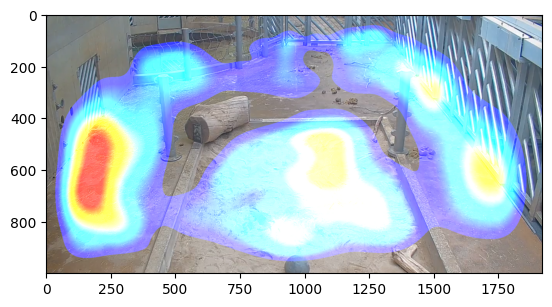

In [58]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('data/images/screenshot1_01_02__11_15.png')

overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


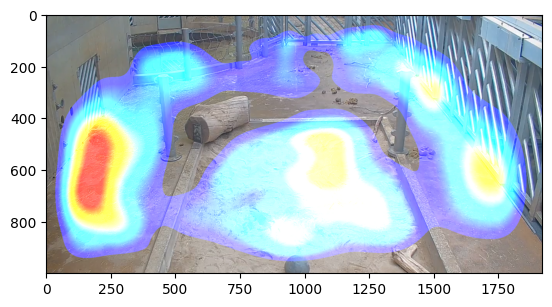

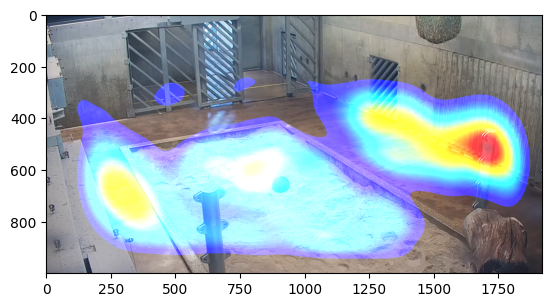

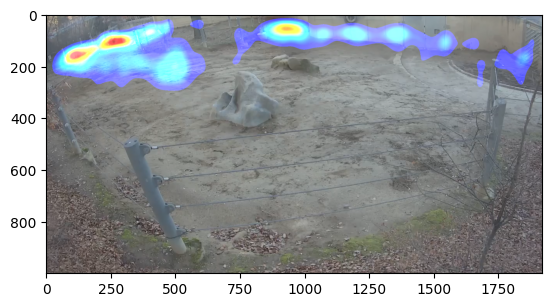

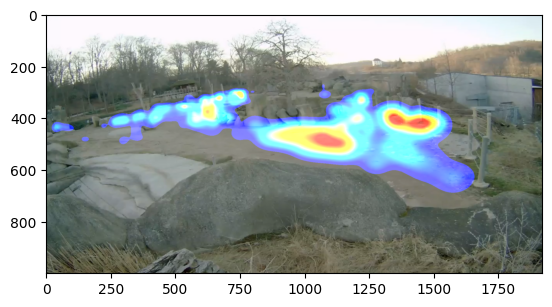

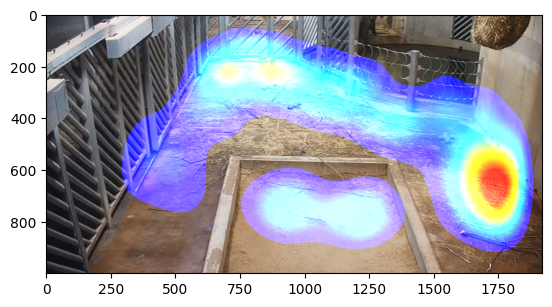

In [71]:
camera_to_path = {
    1: 'data/images/screenshot1_01_02__11_15.png',
    2: 'data/images/screenshot2_04_02__13_15.png',
    4: 'data/images/screenshot4_05_02__14_30.png',
    6: 'data/images/screenshot6_28_01__15_15.png',
    7: 'data/images/screenshot7_29_01__15_15.png'}
for key in camera_to_path.keys():
    heatmap_color = get_heatmap(df, key)
    original_img = cv2.imread(camera_to_path[key])
    overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
    plt.figure()
    plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
    plt.show()
